# Análise de Machine Learning - Ansiedade

Este notebook realiza análise preditiva de ansiedade usando técnicas de Machine Learning.

## 1. Importação de Bibliotecas

In [ ]:
import pandas as pd # Para manipulação e análise de dados tabulares
import numpy as np # Para operações numéricas e arrays multidimensionais
from datetime import datetime # Para trabalhar com datas e calcular a idade
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate # Para divisão de dados, validação cruzada e avaliação de modelos
from sklearn.linear_model import LogisticRegression # Algoritmo de Regressão Logística
from sklearn.ensemble import RandomForestClassifier # Algoritmo Random Forest
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, recall_score, precision_score # Métricas de avaliação de modelos de classificação
from sklearn.preprocessing import StandardScaler # Para padronização de features (escalonamento)
from sklearn.pipeline import Pipeline # Para encadear transformações e modelos
from xgboost import XGBClassifier # Algoritmo XGBoost para classificação
import optuna # Para otimização de hiperparâmetros (Bayesian Optimization)
from optuna.samplers import TPESampler # Amostrador TPE para Optuna
import shap # Para análise de explicabilidade de modelos (SHapley Additive exPlanations)
import matplotlib.pyplot as plt # Para criação de gráficos e visualizações
import warnings # Para gerenciar avisos
warnings.filterwarnings('ignore') # Ignorar avisos para uma saída mais limpa

## 2. Carregamento e Pré-processamento dos Dados

In [ ]:
# Carregar o dataset a partir do Google Drive
df = pd.read_csv("banco_de_dados_20250720.csv", delimiter=';', encoding='latin1')

# Exibir as primeiras linhas do DataFrame para inspeção inicial
print("Primeiras 5 linhas do DataFrame:")
print(df.head())

# Limpar nomes das colunas: remover espaços em branco do início/fim
df.columns = df.columns.str.strip()

# Recodificação da variável target 'Ansioso21' para 'Target_Ansioso'
# Onde 2 = "Ansioso" (codificado como 1) e 1 = "Não Ansioso" (codificado como 0)
df['Target_Ansioso'] = df['Ansioso21'].replace({1: 0, 2: 1})

# Função para calcular a idade a partir da data de nascimento e data de coleta
def calculate_age(birth_date_str, collection_date_str):
    try:
        # Tentar formato de data DD/MM/YYYY para data de nascimento
        if len(birth_date_str.split('/')) == 3:
            birth_date = datetime.strptime(birth_date_str, '%d/%m/%Y')
        # Tentar formato YYYY-MM-DD para data de nascimento
        elif len(birth_date_str.split('-')) == 3:
            birth_date = datetime.strptime(birth_date_str, '%Y-%m-%d')
        else:
            # Retornar NaN se o formato não for reconhecido
            return np.nan

        # A data de coleta geralmente tem um formato MM/DD/YYYY HH:MM, pegar apenas a parte da data
        collection_date = datetime.strptime(collection_date_str.split(' ')[0], '%m/%d/%Y')

        # Calcular idade em anos
        age = collection_date.year - birth_date.year - ((collection_date.month, collection_date.day) < (birth_date.month, birth_date.day))
        return age
    except ValueError:
        try:
            # Tentar formato alternativo MM/DD/YYYY para data de nascimento, caso o primeiro falhe
            birth_date = datetime.strptime(birth_date_str, '%m/%d/%Y')
            collection_date = datetime.strptime(collection_date_str.split(' ')[0], '%m/%d/%Y')
            age = collection_date.year - birth_date.year - ((collection_date.month, collection_date.day) < (birth_date.month, birth_date.day))
            return age
        except:
            # Retornar NaN se houver qualquer erro na conversão ou cálculo
            return np.nan

# Aplicar a função calculate_age para criar a nova coluna 'Idade'
df['Idade'] = df.apply(lambda row: calculate_age(row['Datadenasci2'], row['Datadecol1']), axis=1)

# Definir as listas de features contínuas e categóricas que serão usadas no modelo
continuous_features = ['Horasdia7', 'Tempo17', 'Tempomax22', 'Dias23', 'Horas24', 'Episodio25', 'Idade']
categorical_features = ['Sexo3', 'Estudo5', 'Trabalho6', 'RelaConj8', 'Mora9', 'Crença10', 'Atividade11',
                        'Face12', 'Insta13', 'Twitter14', 'Whats15', 'Apprela16', 'Outraspessoas18',
                        'Insatisafação19', 'Aparencia20']

# Imputação de valores ausentes:
# Para features contínuas: preencher com a mediana (menos sensível a outliers)
for col in continuous_features:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# Para features categóricas: converter para tipo 'object' e preencher com a moda
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype('object') # Garante que a coluna é tratada como categórica
        df[col].fillna(df[col].mode()[0], inplace=True) # Preenche com o valor mais frequente

# Selecionar apenas as colunas relevantes para o modelo de Machine Learning
all_features = continuous_features + categorical_features + ['Target_Ansioso']
df_ml = df[all_features].copy() # Cria uma cópia para evitar SettingWithCopyWarning

# One-Hot Encoding para as features categóricas
# Transforma variáveis categóricas em um formato binário, criando novas colunas
# `drop_first=True` evita a multicolinearidade, removendo a primeira categoria de cada variável
df_ml = pd.get_dummies(df_ml, columns=categorical_features, drop_first=True)

print("\nEstrutura final do DataFrame após pré-processamento:")
print(df_ml.info()) # Exibe informações sobre o DataFrame (tipos de dados, não-nulos)
print("\nDistribuição da variável target 'Target_Ansioso':")
print(df_ml['Target_Ansioso'].value_counts()) # Mostra o balanço das classes da variável target

Primeiras 5 linhas do DataFrame:
   NumID        Datadecol1 Datadenasci2  Sexo3  Estado4  Estudo5  Trabalho6  \
0      1  31/03/2020 11:35   10/03/1990      1      1.0        2          1   
1      2  31/03/2020 11:42   26/11/1988      2      1.0        1          1   
2      3  31/03/2020 11:47   16/09/1987      2      1.0        2          1   
3      4  31/03/2020 11:56   16/01/1989      1      1.0        2          1   
4      5  31/03/2020 12:06   06/04/1989      2      1.0        2          1   

   Horasdia7  RelaConj8  Mora9  ...  UCLA11  UCLA12  UCLA13  UCLA14  UCLA15  \
0         40        1.0      2  ...       1       2       1       2       1   
1         45        1.0      1  ...       0       0       0       0       0   
2         35        1.0      2  ...       0       1       1       1       1   
3         12        1.0      2  ...       0       1       1       2       2   
4         40        1.0      2  ...       0       0       0       0       0   

   UCLA16  UCLA17

## 3. Treinamento e Avaliação dos Modelos

In [ ]:
# Configurar seeds para garantir a reprodutibilidade dos resultados
SEED = 42
np.random.seed(SEED)
import random
random.seed(SEED)

# Separar features (X) da variável target (y)
X = df_ml.drop('Target_Ansioso', axis=1)
y = df_ml['Target_Ansioso']

# Dividir os dados em conjuntos de treino e teste
# test_size=0.2 significa 20% dos dados para teste
# random_state=SEED garante que a divisão seja a mesma a cada execução
# stratify=y garante que a proporção das classes da variável target seja mantida em ambos os conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Configurar a validação cruzada estratificada (Stratified K-Fold)
# n_splits=5 para 5 folds
# shuffle=True para embaralhar os dados antes da divisão
# random_state=SEED para reprodutibilidade
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Definir as métricas de avaliação que serão calculadas durante a validação cruzada
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc', # Área sob a curva ROC (AUC-ROC) é uma métrica chave para classificação binária
    'recall': 'recall', # Sensibilidade
    'precision': 'precision',
    'f1': 'f1' # Média harmônica de precisão e recall
}

print("\n" + "="*80)
print("ETAPA 2: OTIMIZAÇÃO DE HIPERPARÂMETROS - OPTUNA (TPE/Bayesian Search)")
print("="*80)

# Função objetivo para otimização de hiperparâmetros do Random Forest
def objective_rf(trial):
    # Sugerir hiperparâmetros para o Random Forest
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300), # Número de árvores
        'max_depth': trial.suggest_int('max_depth', 3, 15), # Profundidade máxima da árvore
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), # Número mínimo de amostras para dividir um nó
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10), # Número mínimo de amostras em um nó folha
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]), # Número de features a considerar em cada split
        'random_state': SEED, # Garante reprodutibilidade
        'n_jobs': 1 # Usar 1 CPU para garantir reprodutibilidade e evitar problemas com paralelização em Optuna
    }

    model = RandomForestClassifier(**params)
    # Criar um pipeline com escalonamento e o classificador
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Padroniza as features
        ('classifier', model)
    ])

    # Realizar validação cruzada e retornar a média do AUC-ROC
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', return_train_score=False)
    return scores['test_score'].mean()

# Função objetivo para otimização de hiperparâmetros da Regressão Logística
def objective_lr(trial):
    # Sugerir tipo de penalidade
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    # O solver 'liblinear' é adequado para penalidades l1 e l2 e conjuntos de dados menores
    solver = 'liblinear'

    # Sugerir hiperparâmetros para a Regressão Logística
    params = {
        'C': trial.suggest_float('C', 0.001, 100.0, log=True), # Inverso da força de regularização (menor C = maior regularização)
        'penalty': penalty,
        'solver': solver,
        'random_state': SEED, # Garante reprodutibilidade
        'max_iter': 1000 # Número máximo de iterações para convergir
    }

    model = LogisticRegression(**params)
    # Criar um pipeline com escalonamento e o classificador
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Padroniza as features
        ('classifier', model)
    ])

    # Realizar validação cruzada e retornar a média do AUC-ROC
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', return_train_score=False)
    return scores['test_score'].mean()

# Função objetivo para otimização de hiperparâmetros do XGBoost
def objective_xgb(trial):
    # Sugerir hiperparâmetros para o XGBoost
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300), # Número de árvores
        'max_depth': trial.suggest_int('max_depth', 3, 15), # Profundidade máxima da árvore
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), # Taxa de aprendizado
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # Proporção de amostras para treinar cada árvore
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # Proporção de colunas para treinar cada árvore
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # Peso mínimo da soma das instâncias (um nó filho precisa ter pelo menos isso)
        'gamma': trial.suggest_float('gamma', 0.0, 0.5), # Redução mínima de perda necessária para fazer uma partição adicional em um nó folha da árvore
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0), # L1 regularização nos pesos
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0), # L2 regularização nos pesos
        'random_state': SEED, # Garante reprodutibilidade
        'eval_metric': 'logloss', # Métrica de avaliação para a otimização
        'n_jobs': 1 # Usar 1 CPU para garantir reprodutibilidade e evitar problemas com paralelização em Optuna
    }

    model = XGBClassifier(**params)
    # Criar um pipeline com escalonamento e o classificador
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # Padroniza as features
        ('classifier', model)
    ])

    # Realizar validação cruzada e retornar a média do AUC-ROC
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', return_train_score=False)
    return scores['test_score'].mean()

print("\nOtimizando Random Forest...")
# Criar um estudo Optuna para Random Forest, maximizando o AUC-ROC
# TPESampler é um algoritmo de otimização bayesiana
study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED))
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True) # Executar 50 tentativas de otimização

print(f"\nMelhores hiperparâmetros (Random Forest):")
print(study_rf.best_params)
print(f"Melhor AUC-ROC (CV): {study_rf.best_value:.4f}")

print("\nOtimizando Regressão Logística...")
# Criar um estudo Optuna para Regressão Logística, maximizando o AUC-ROC
study_lr = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED))
study_lr.optimize(objective_lr, n_trials=50, show_progress_bar=True) # Executar 50 tentativas de otimização

print(f"\nMelhores hiperparâmetros (Regressão Logística):")
print(study_lr.best_params)
print(f"Melhor AUC-ROC (CV): {study_lr.best_value:.4f}")

print("\nOtimizando XGBoost...")
# Criar um estudo Optuna para XGBoost, maximizando o AUC-ROC
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True) # Executar 50 tentativas de otimização

print(f"\nMelhores hiperparâmetros (XGBoost):")
print(study_xgb.best_params)
print(f"Melhor AUC-ROC (CV): {study_xgb.best_value:.4f}")

print("\n" + "="*80)
print("ETAPA 3: AVALIAÇÃO NO CONJUNTO DE TESTE - MODELOS OTIMIZADOS")
print("="*80)

# Reobter os melhores parâmetros da Regressão Logística e garantir o solver
lr_params = study_lr.best_params.copy()
lr_params['solver'] = 'liblinear' # Garante consistência com a função objetivo

# Preparar os parâmetros finais do Random Forest
rf_final_params = study_rf.best_params.copy()
rf_final_params['n_jobs'] = 1 # Garantir n_jobs=1 para reprodutibilidade com os modelos finais
rf_final_params['random_state'] = SEED # Adicionar random_state para consistência

# Preparar os parâmetros finais do XGBoost
xgb_final_params = study_xgb.best_params.copy()
xgb_final_params['eval_metric'] = 'logloss' # Garantir consistência com a métrica de avaliação da função objetivo
xgb_final_params['n_jobs'] = 1 # Garantir n_jobs=1 para reprodutibilidade com os modelos finais
xgb_final_params['random_state'] = SEED # Adicionar random_state para consistência

# Instanciar os modelos com os hiperparâmetros otimizados
models_optimized = {
    'Regressão Logística (Otimizada)': LogisticRegression(**lr_params, random_state=SEED, max_iter=1000),
    'Random Forest (Otimizado)': RandomForestClassifier(**rf_final_params),
    'XGBoost (Otimizado)': XGBClassifier(**xgb_final_params)
}

final_results = {}
# Avaliar cada modelo otimizado no conjunto de teste
for name, model in models_optimized.items():
    # Criar pipeline com escalonamento e o modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Treinar o pipeline com os dados de treino
    pipeline.fit(X_train, y_train)

    # Prever probabilidades e classes no conjunto de teste
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva
    y_pred = pipeline.predict(X_test) # Classes preditas

    # Calcular as métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    sensitivity = recall_score(y_test, y_pred, pos_label=1) # Recall para a classe positiva
    specificity = recall_score(y_test, y_pred, pos_label=0) # Recall para a classe negativa
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() # Valores da matriz de confusão

    # Armazenar os resultados
    final_results[name] = {
        'Acurácia': accuracy,
        'AUC-ROC': auc_roc,
        'Sensibilidade (Recall)': sensitivity,
        'Especificidade': specificity,
        'Precisão (PPV)': precision,
        'F1-Score': f1,
        'TP': tp, 'FN': fn, 'FP': fp, 'TN': tn
    }

# Criar um DataFrame com os resultados finais para fácil visualização
final_results_df = pd.DataFrame(final_results).T.round(4)
print("\nDesempenho dos Modelos Otimizados (Conjunto de Teste):")
print(final_results_df)

# Instanciar modelos finais para cálculo de importância das features com n_jobs=1 explicitamente
# Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(**rf_final_params))
])
rf_pipeline.fit(X_train, y_train)

rf_model = rf_pipeline.named_steps['classifier']
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(**xgb_final_params))
])
xgb_pipeline.fit(X_train, y_train)

xgb_model = xgb_pipeline.named_steps['classifier']
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

print("\n" + "="*80)
print("IMPORTÂNCIA DAS FEATURES")
print("="*80)

print("\nTop 10 Variáveis Mais Importantes (Random Forest Otimizado):")
print(feature_importances_rf.sort_values(ascending=False).head(10))

print("\nTop 10 Variáveis Mais Importantes (XGBoost Otimizado):")
print(feature_importances_xgb.sort_values(ascending=False).head(10))

[I 2025-12-11 00:00:38,813] A new study created in memory with name: no-name-cae108ab-54d6-44c8-a76d-77155d69d4b6



ETAPA 2: OTIMIZAÇÃO DE HIPERPARÂMETROS - OPTUNA (TPE/Bayesian Search)

Otimizando Random Forest...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-11 00:00:41,173] Trial 0 finished with value: 0.7087646652864045 and parameters: {'n_estimators': 144, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7087646652864045.
[I 2025-12-11 00:00:44,534] Trial 1 finished with value: 0.7081339621194693 and parameters: {'n_estimators': 267, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7087646652864045.
[I 2025-12-11 00:00:46,162] Trial 2 finished with value: 0.6788033893106358 and parameters: {'n_estimators': 95, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.7087646652864045.
[I 2025-12-11 00:00:46,975] Trial 3 finished with value: 0.71243961352657 and parameters: {'n_estimators': 85, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.71243961352657.
[I 2

[I 2025-12-11 00:02:32,254] A new study created in memory with name: no-name-38097b79-782f-418e-8e1f-b935834f7ee2


[I 2025-12-11 00:02:32,244] Trial 49 finished with value: 0.7115558622804998 and parameters: {'n_estimators': 204, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 41 with value: 0.7174219768422667.

Melhores hiperparâmetros (Random Forest):
{'n_estimators': 161, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}
Melhor AUC-ROC (CV): 0.7174

Otimizando Regressão Logística...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-11 00:02:32,381] Trial 0 finished with value: 0.6654359328272372 and parameters: {'penalty': 'l2', 'C': 4.5705630998014515}. Best is trial 0 with value: 0.6654359328272372.
[I 2025-12-11 00:02:32,470] Trial 1 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.0060252157362038605}. Best is trial 0 with value: 0.6654359328272372.
[I 2025-12-11 00:02:32,545] Trial 2 finished with value: 0.6672954528026992 and parameters: {'penalty': 'l2', 'C': 1.0129197956845732}. Best is trial 2 with value: 0.6672954528026992.
[I 2025-12-11 00:02:32,643] Trial 3 finished with value: 0.6651272908519286 and parameters: {'penalty': 'l1', 'C': 70.72114131472235}. Best is trial 2 with value: 0.6672954528026992.
[I 2025-12-11 00:02:32,717] Trial 4 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.008111941985431923}. Best is trial 2 with value: 0.6672954528026992.
[I 2025-12-11 00:02:32,806] Trial 5 finished with value: 0.6700866497967948 and parameters: {'penalty': 'l

[I 2025-12-11 00:02:37,273] A new study created in memory with name: no-name-1098a788-6266-4804-9b77-e77dc9d41488


[I 2025-12-11 00:02:37,266] Trial 49 finished with value: 0.6824725864580936 and parameters: {'penalty': 'l1', 'C': 0.6762200072785836}. Best is trial 43 with value: 0.7032436162870945.

Melhores hiperparâmetros (Regressão Logística):
{'penalty': 'l1', 'C': 0.18011797753410091}
Melhor AUC-ROC (CV): 0.7032

Otimizando XGBoost...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-11 00:02:37,625] Trial 0 finished with value: 0.671056667433479 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.671056667433479.
[I 2025-12-11 00:02:37,987] Trial 1 finished with value: 0.6536922015182884 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 0 with value: 0.671056667433479.
[I 2025-12-11 00:02:38,328] Trial 2 finished with value: 0.6841346522505942 and parameters: {'n_estimators': 158, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

In [ ]:
print("\n" + "="*80)
print("RESUMO GERAL DAS MÉTRICAS DE DESEMPENHO DOS MODELOS")
print("="*80)

final_results_df_renamed = final_results_df.rename(columns={
    'Acurácia': 'Teste_Acuracia',
    'AUC-ROC': 'Teste_AUC_ROC',
    'Sensibilidade (Recall)': 'Teste_Recall',
    'Especificidade': 'Teste_Especificidade',
    'Precisão (PPV)': 'Teste_Precisao',
    'F1-Score': 'Teste_F1_Score',
    'TP': 'Teste_TP', 'FN': 'Teste_FN', 'FP': 'Teste_FP', 'TN': 'Teste_TN'
})

all_metrics_df = final_results_df_renamed

print(all_metrics_df.round(4).to_string())

# all_metrics_df.to_csv('todas_as_metricas_modelos.csv', index=True)
# print("\n✓ DataFrame combinado de métricas salvo como: todas_as_metricas_modelos.csv")


RESUMO GERAL DAS MÉTRICAS DE DESEMPENHO DOS MODELOS
                                 Teste_Acuracia  Teste_AUC_ROC  Teste_Recall  Teste_Especificidade  Teste_Precisao  Teste_F1_Score  Teste_TP  Teste_FN  Teste_FP  Teste_TN
Regressão Logística (Otimizada)          0.6719         0.7015        0.7143                0.6207          0.6944          0.7042      25.0      10.0      11.0      18.0
Random Forest (Otimizado)                0.6250         0.7054        0.7143                0.5172          0.6410          0.6757      25.0      10.0      14.0      15.0
XGBoost (Otimizado)                      0.6562         0.6985        0.6571                0.6552          0.6970          0.6765      23.0      12.0      10.0      19.0


# Análise de Explicabilidade com SHAP

SHAP (SHapley Additive exPlanations) é uma técnica de interpretabilidade que explica a contribuição de cada feature para as predições do modelo.

### 1. Geração dos valores de Shap

In [ ]:
# Configurar estilo dos gráficos para visualização
plt.style.use('default')
shap.initjs() # Inicializa o Javascript para plots interativos do SHAP

print("="*80)
print("ANÁLISE DE EXPLICABILIDADE - SHAP")
print("="*80)

# Treinar o melhor modelo XGBoost com os parâmetros otimizados
best_model = XGBClassifier(**study_xgb.best_params)
best_model.fit(X_train, y_train)

# Criar explicador SHAP para XGBoost (TreeExplainer é otimizado para modelos baseados em árvore)
print("\n1. Criando explicador SHAP para XGBoost...")
explainer_xgb = shap.TreeExplainer(best_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Criar e treinar o modelo Random Forest com os melhores parâmetros
print("2. Criando explicador SHAP para Random Forest...")
rf_model_best = RandomForestClassifier(**study_rf.best_params)
rf_model_best.fit(X_train, y_train)
explainer_rf = shap.TreeExplainer(rf_model_best)
shap_values_rf = explainer_rf.shap_values(X_test)

# Reobter os melhores parâmetros da Regressão Logística
lr_params = study_lr.best_params.copy()
lr_params['solver'] = 'liblinear' # Garante consistência, Optuna já faz isso

print("3. Criando e treinando o Pipeline para Regressão Logística (Otimizada)...")
# Criar e treinar um pipeline para Regressão Logística com escalonamento
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(**lr_params, random_state=SEED, max_iter=1000)) # max_iter e random_state adicionados para consistência
])
lr_pipeline.fit(X_train, y_train)

# Obter o scaler e o classificador ajustados do pipeline
scaler_lr = lr_pipeline.named_steps['scaler']
classifier_lr = lr_pipeline.named_steps['classifier']

# Transformar X_train e X_test usando o scaler ajustado
X_train_scaled_lr = scaler_lr.transform(X_train)
X_test_scaled_lr = scaler_lr.transform(X_test)

# Converter para DataFrame para reter os nomes das features para o SHAP
X_train_scaled_df_lr = pd.DataFrame(X_train_scaled_lr, columns=X_train.columns, index=X_train.index)
X_test_scaled_df_lr = pd.DataFrame(X_test_scaled_lr, columns=X_test.columns, index=X_test.index)

# Criar explicador SHAP para Regressão Logística (LinearExplainer para modelos lineares)
print("4. Criando explicador SHAP para Regressão Logística...")
explainer_lr = shap.LinearExplainer(classifier_lr, X_train_scaled_df_lr)
shap_values_lr = explainer_lr.shap_values(X_test_scaled_df_lr)

# Garantir que shap_values sejam 2D (amostras x features) para plots de classificação binária.
# Se for uma lista de arrays (um por classe), pegar o array para a classe positiva (índice 1).
# Se for um array 3D (amostras, features, classes), pegar a fatia para a classe positiva (índice 1).

# Processar shap_values_xgb para garantir o formato correto (classe positiva)
if isinstance(shap_values_xgb, list):
    shap_values_xgb = shap_values_xgb[1]
elif len(shap_values_xgb.shape) == 3 and shap_values_xgb.shape[2] == 2:
    shap_values_xgb = shap_values_xgb[:, :, 1]

# Processar shap_values_rf para garantir o formato correto (classe positiva)
if isinstance(shap_values_rf, list):
    shap_values_rf = shap_values_rf[1]
elif len(shap_values_rf.shape) == 3 and shap_values_rf.shape[2] == 2:
    shap_values_rf = shap_values_rf[:, :, 1]

# Processar shap_values_lr para garantir o formato correto (classe positiva)
if isinstance(shap_values_lr, list):
    shap_values_lr = shap_values_lr[1]
elif len(shap_values_lr.shape) == 3 and shap_values_lr.shape[2] == 2:
    shap_values_lr = shap_values_lr[:, :, 1]

print("\n✓ Explicadores SHAP criados com sucesso!")
print(f"Shape dos SHAP values (XGBoost): {shap_values_xgb.shape}")
print(f"Shape dos SHAP values (Random Forest): {shap_values_rf.shape}")
print(f"Shape dos SHAP values (Regressão Logística): {shap_values_lr.shape}")

ANÁLISE DE EXPLICABILIDADE - SHAP

1. Criando explicador SHAP para XGBoost...
2. Criando explicador SHAP para Random Forest...
3. Criando e treinando o Pipeline para Regressão Logística (Otimizada)...
4. Criando explicador SHAP para Regressão Logística...

✓ Explicadores SHAP criados com sucesso!
Shape dos SHAP values (XGBoost): (64, 23)
Shape dos SHAP values (Random Forest): (64, 23)
Shape dos SHAP values (Regressão Logística): (64, 23)


### 2. Dependence Plots - Relação entre Features e Predições


Top 5 features mais importantes (XGBoost): ['Tempo17', 'Insatisafação19_2', 'Tempomax22', 'Idade', 'RelaConj8_2.0']

Gerando Dependence Plots (XGBoost) com incidância de terceira variável...
Dependence Plot para: Tempo17 (com interação)


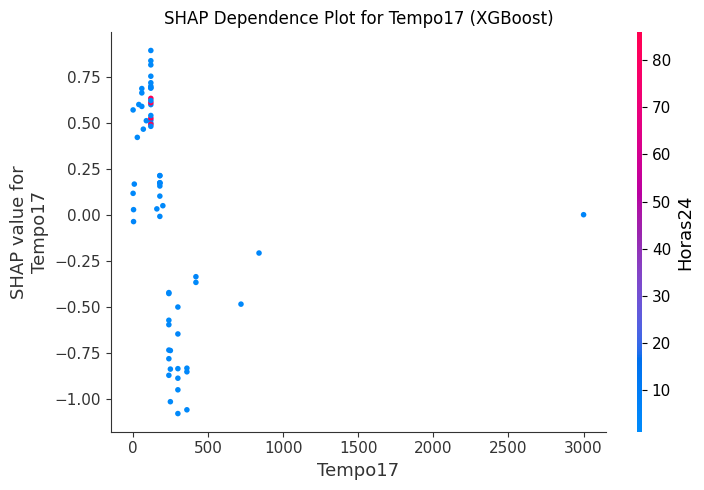

Dependence Plot para: Insatisafação19_2 (com interação)


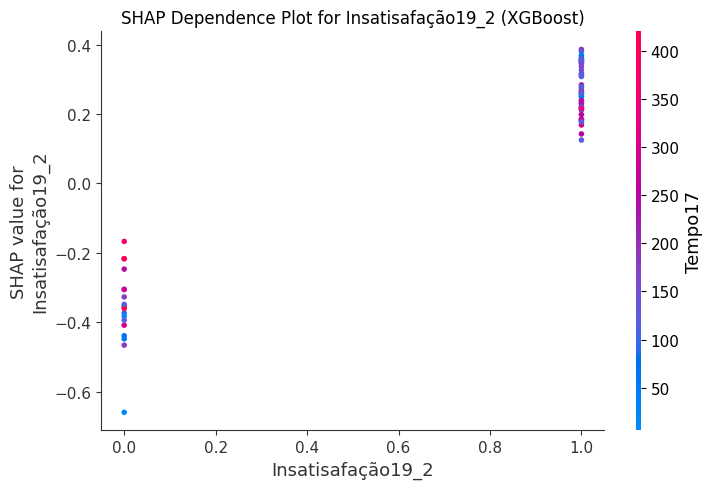

Dependence Plot para: Tempomax22 (com interação)


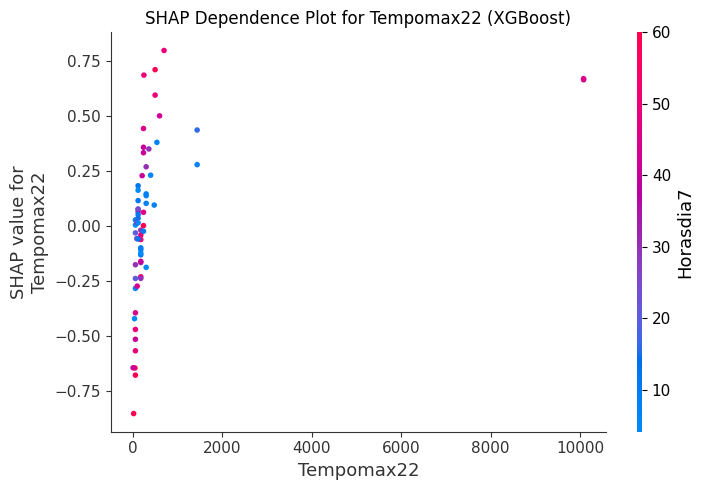

Dependence Plot para: Idade (com interação)


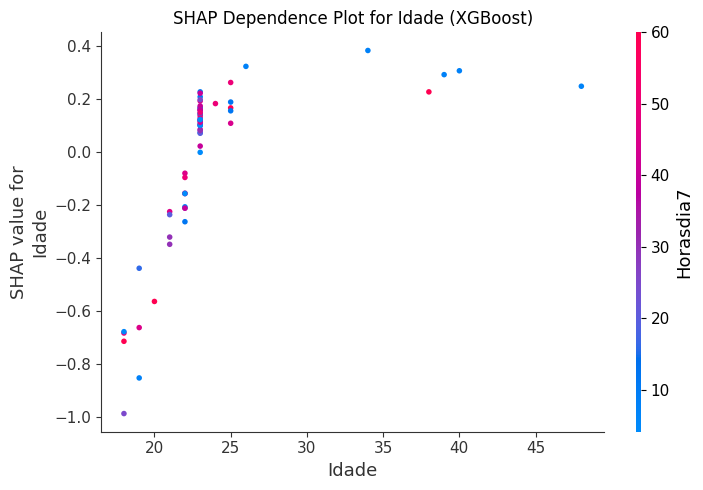

Dependence Plot para: RelaConj8_2.0 (com interação)


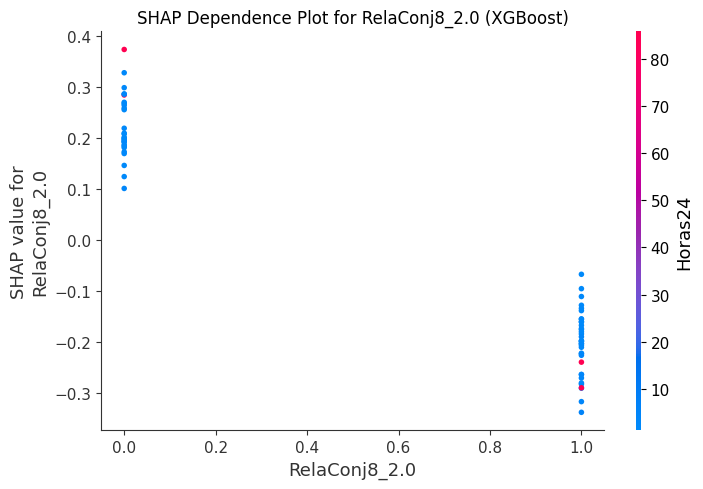


Top 5 features mais importantes (Random Forest): ['Tempo17', 'Tempomax22', 'Insatisafação19_2', 'Episodio25', 'Twitter14_2']

Gerando Dependence Plots (Random Forest) com incidância de terceira variável...
Dependence Plot para: Tempo17 (com interação)


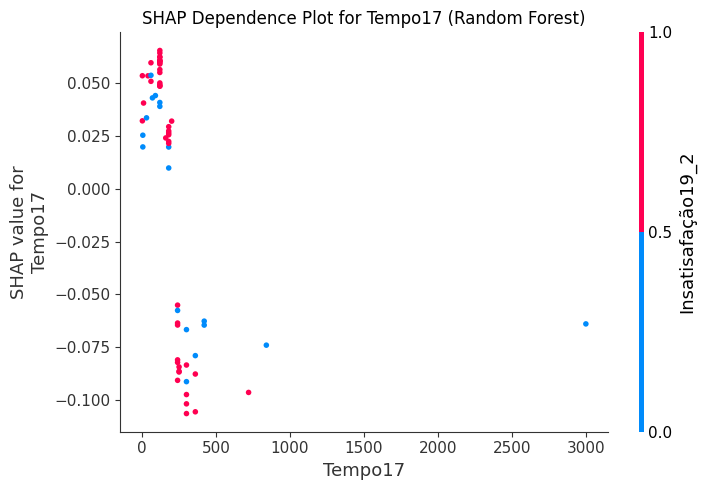

Dependence Plot para: Tempomax22 (com interação)


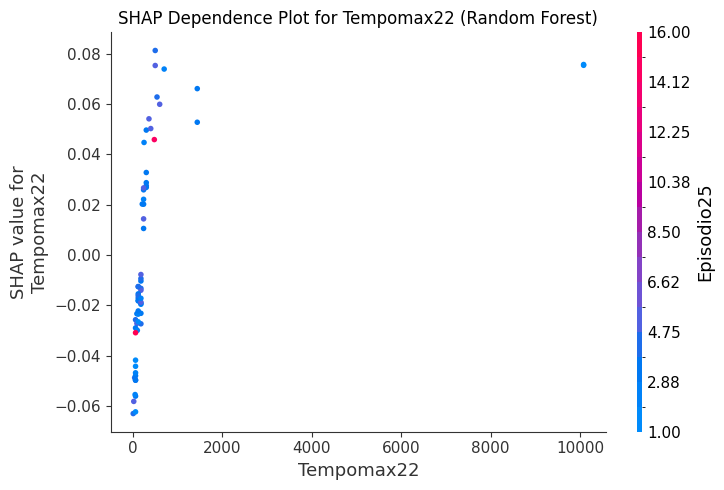

Dependence Plot para: Insatisafação19_2 (com interação)


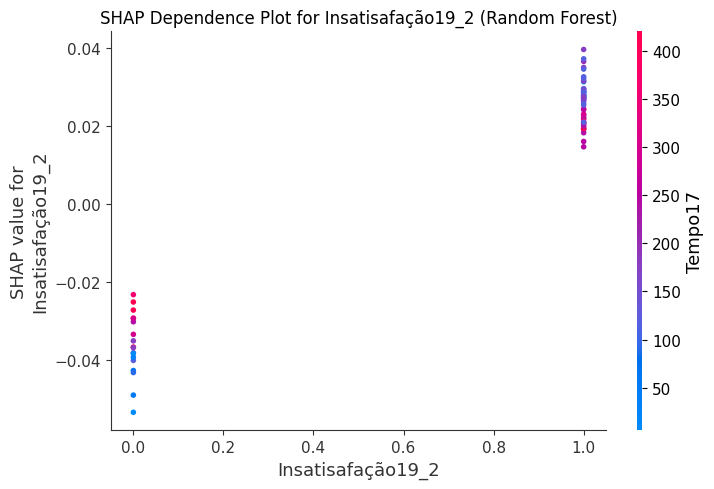

Dependence Plot para: Episodio25 (com interação)


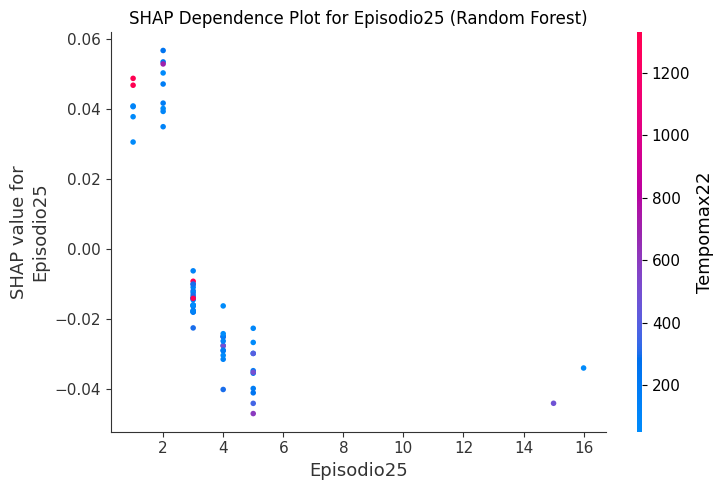

Dependence Plot para: Twitter14_2 (com interação)


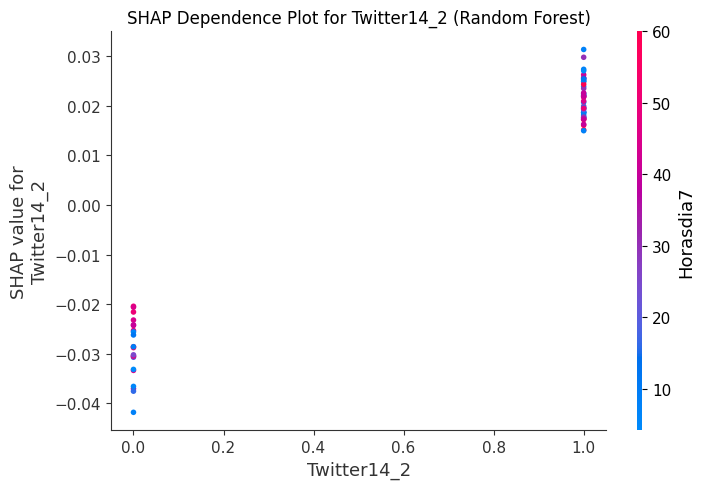


Top 5 features mais importantes (Regressão Logística): ['Insatisafação19_2', 'Outraspessoas18_2', 'Twitter14_2', 'Tempo17', 'RelaConj8_2.0']

Gerando Dependence Plots (Regressão Logística) com incidância de terceira variável...
Dependence Plot para: Insatisafação19_2 (com interação)


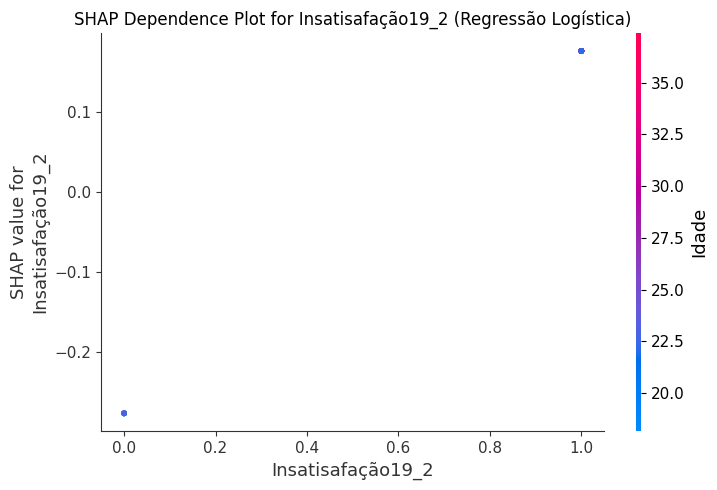

Dependence Plot para: Outraspessoas18_2 (com interação)


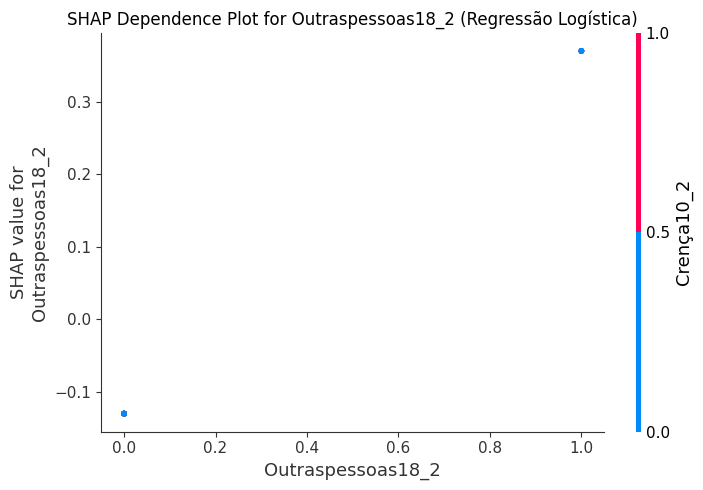

Dependence Plot para: Twitter14_2 (com interação)


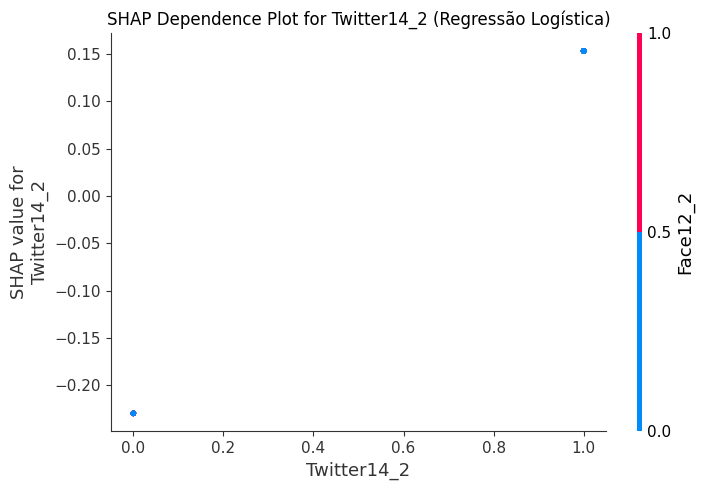

Dependence Plot para: Tempo17 (com interação)


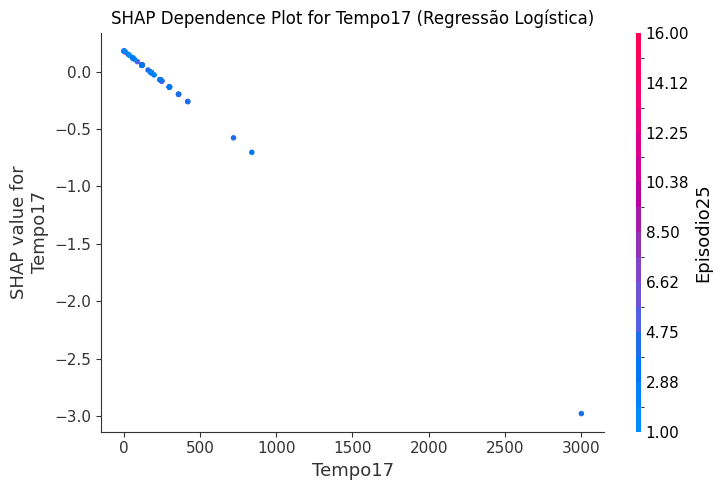

Dependence Plot para: RelaConj8_2.0 (com interação)


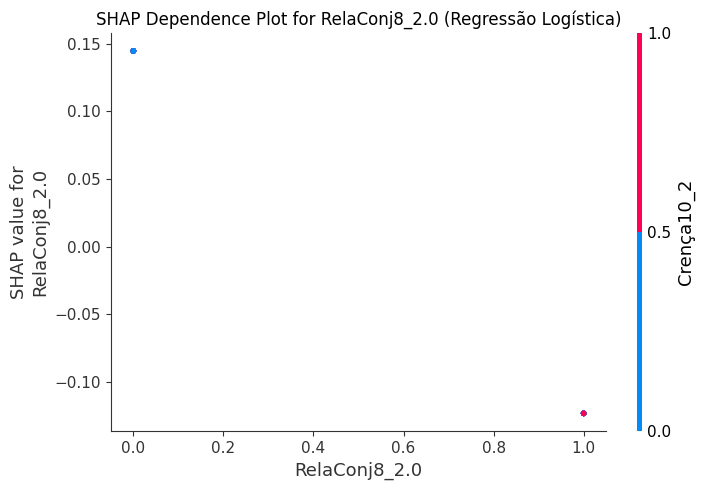


✓ Todos os Dependence Plots com interação foram gerados.


In [ ]:
import matplotlib.pyplot as plt

# --- Dependence Plots para XGBoost ---
# Identificar as top 5 features mais importantes para o modelo XGBoost
mean_abs_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)
top_features_idx_xgb = np.argsort(mean_abs_shap_xgb)[-5:][::-1]
top_features_xgb = X_test.columns[top_features_idx_xgb] # Nomes das features correspondentes

print(f"\nTop 5 features mais importantes (XGBoost): {list(top_features_xgb)}")

print("\nGerando Dependence Plots (XGBoost) com incidância de terceira variável...")
# Gerar Dependence Plots para cada uma das top 5 features do XGBoost
# interaction_index='auto' permite que o SHAP encontre a feature que mais interage
for feature in top_features_xgb:
    print(f"Dependence Plot para: {feature} (com interação)")
    shap.dependence_plot(feature, shap_values_xgb, X_test, interaction_index='auto', show=False)
    plt.title(f"SHAP Dependence Plot for {feature} (XGBoost)") # Título do gráfico
    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    # plt.savefig(f'shap_dependence_xgb_{feature}.png') # Linha comentada para salvar o gráfico
    plt.show() # Exibe o gráfico

# --- Dependence Plots para Random Forest ---
# Identificar as top 5 features mais importantes para o modelo Random Forest
mean_abs_shap_rf = np.abs(shap_values_rf).mean(axis=0)
top_features_idx_rf = np.argsort(mean_abs_shap_rf)[-5:][::-1]
top_features_rf = X_test.columns[top_features_idx_rf] # Nomes das features correspondentes

print(f"\nTop 5 features mais importantes (Random Forest): {list(top_features_rf)}")

print("\nGerando Dependence Plots (Random Forest) com incidância de terceira variável...")
# Gerar Dependence Plots para cada uma das top 5 features do Random Forest
for feature in top_features_rf:
    print(f"Dependence Plot para: {feature} (com interação)")
    shap.dependence_plot(feature, shap_values_rf, X_test, interaction_index='auto', show=False)
    plt.title(f"SHAP Dependence Plot for {feature} (Random Forest)") # Título do gráfico
    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    # plt.savefig(f'shap_dependence_rf_{feature}.png') # Linha comentada para salvar o gráfico
    plt.show() # Exibe o gráfico

# --- Dependence Plots para Regressão Logística ---
# Identificar as top 5 features mais importantes para o modelo Regressão Logística
mean_abs_shap_lr = np.abs(shap_values_lr).mean(axis=0)
top_features_idx_lr = np.argsort(mean_abs_shap_lr)[-5:][::-1]
top_features_lr = X_test.columns[top_features_idx_lr] # Usar colunas originais de X_test para nomes

print(f"\nTop 5 features mais importantes (Regressão Logística): {list(top_features_lr)}")

print("\nGerando Dependence Plots (Regressão Logística) com incidância de terceira variável...")

# Criar uma cópia de X_test e converter colunas booleanas para inteiros para plotagem
# Isso é necessário porque alguns plots SHAP podem ter problemas com tipos booleanos diretamente
X_test_numeric_bool_original = X_test.copy()
for col in X_test_numeric_bool_original.select_dtypes(include='bool').columns:
    X_test_numeric_bool_original[col] = X_test_numeric_bool_original[col].astype(int)

# Gerar Dependence Plots para cada uma das top 5 features da Regressão Logística
for feature in top_features_lr:
    print(f"Dependence Plot para: {feature} (com interação)")
    shap.dependence_plot(feature, shap_values_lr, X_test_numeric_bool_original, interaction_index='auto', show=False)
    plt.title(f"SHAP Dependence Plot for {feature} (Regressão Logística)") # Título do gráfico
    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show() # Exibe o gráfico

print("\n✓ Todos os Dependence Plots com interação foram gerados.")

### 3. Summary Plots

Gerando Summary Plot interativo (XGBoost)...


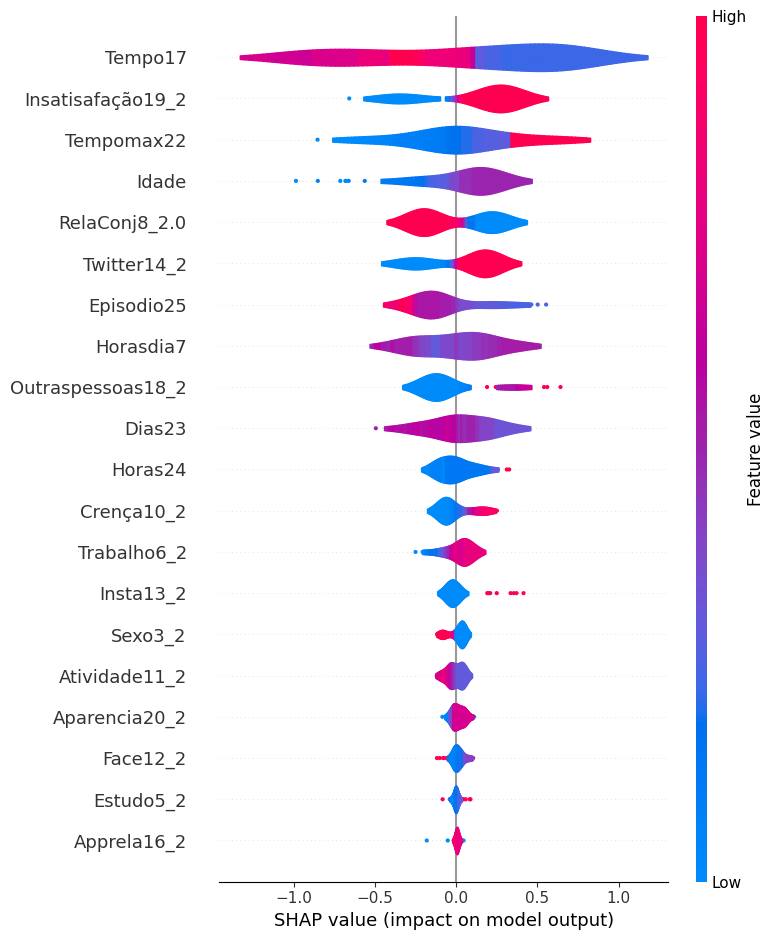


✓ Summary Plot interativo (XGBoost) gerado.
Gerando Summary Plot interativo (Random Forest)...


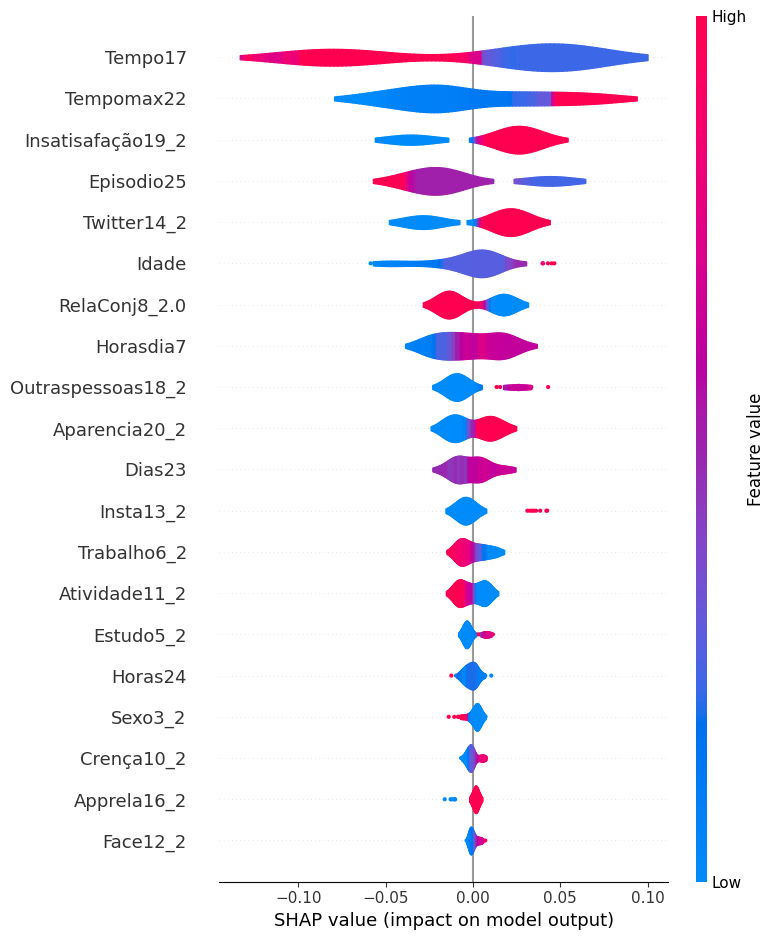


✓ Summary Plot interativo (Random Forest) gerado.

Gerando Summary Plot interativo (Regressão Logística)...


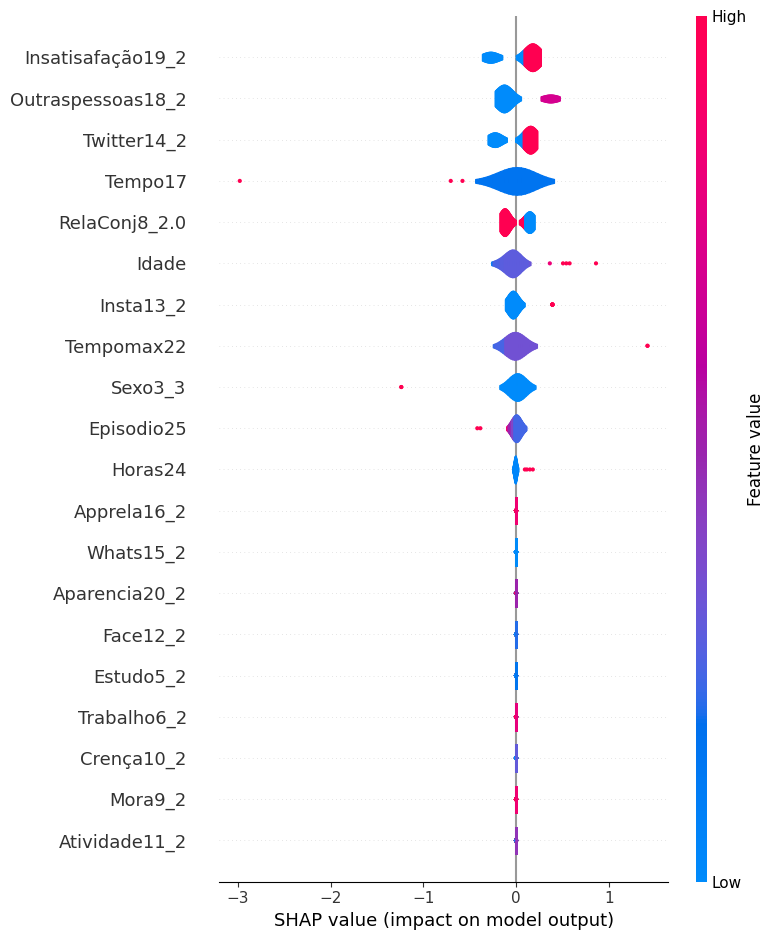


✓ Summary Plot interativo (Regressão Logística) gerado.


In [ ]:
print("Gerando Summary Plot interativo (XGBoost)...")

# Criar uma cópia de X_test e converter colunas booleanas para inteiros
# Isso é importante para que o SHAP possa processar corretamente as features para o plot
X_test_numeric_bool_xgb = X_test.copy()
for col in X_test_numeric_bool_xgb.select_dtypes(include='bool').columns:
    X_test_numeric_bool_xgb[col] = X_test_numeric_bool_xgb[col].astype(int)

# Gerar o Summary Plot para XGBoost (tipo 'violin' mostra a distribuição dos valores SHAP)
shap.summary_plot(shap_values_xgb, X_test_numeric_bool_xgb, plot_type="violin", show=True)
print("\n✓ Summary Plot interativo (XGBoost) gerado.")


print("Gerando Summary Plot interativo (Random Forest)...")

# Criar uma cópia de X_test e converter colunas booleanas para inteiros
X_test_numeric_bool = X_test.copy()
for col in X_test_numeric_bool.select_dtypes(include='bool').columns:
    X_test_numeric_bool[col] = X_test_numeric_bool[col].astype(int)

# Gerar o Summary Plot para Random Forest
shap.summary_plot(shap_values_rf, X_test_numeric_bool, plot_type="violin", show=True)
print("\n✓ Summary Plot interativo (Random Forest) gerado.")


print("\nGerando Summary Plot interativo (Regressão Logística)...")

# Criar uma cópia de X_test e converter colunas booleanas para inteiros para o plot LR
X_test_numeric_bool_lr_plot = X_test.copy()
for col in X_test_numeric_bool_lr_plot.select_dtypes(include='bool').columns:
    X_test_numeric_bool_lr_plot[col] = X_test_numeric_bool_lr_plot[col].astype(int)

# Gerar o Summary Plot para Regressão Logística
shap.summary_plot(shap_values_lr, X_test_numeric_bool_lr_plot, plot_type="violin", show=True)
print("\n✓ Summary Plot interativo (Regressão Logística) gerado.")